In [1]:
# using %matplotlib inline to immediatly draw plot after run
%matplotlib inline 

# imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import dotenv
import datetime
import os
import pickle
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FunctionTransformer, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from abc import ABC, abstractmethod



"""prepare environment variable"""
project_dir = os.path.join(os.path.abspath(''), os.pardir)
dotenv_path = os.path.join(project_dir, '.env')
dotenv.load_dotenv(dotenv_path)

True

# Get Data

In [2]:
def check_path_existance(path):
    return os.path.exists(path)

dataset_folder = os.path.join(project_dir, os.getenv('RAW_FOLDER'), 'house-prices-advanced-regression-techniques')
train_df = None
test_df = None

if check_path_existance(dataset_folder):   
    train_df = pd.read_csv(os.path.join(dataset_folder, 'train.csv'))
    test_df = pd.read_csv(os.path.join(dataset_folder, 'test.csv'))

In [3]:
train_df.loc[:, ('MSSubClass')] = train_df.loc[:, ('MSSubClass')].astype(str)
test_df.loc[:, ('MSSubClass')] = test_df.loc[:, ('MSSubClass')].astype(str)

# numerical_columns = train_df.select_dtypes(include=['int64', 'float64']).columns
# categorical_columns = train_df.select_dtypes(include=['object']).columns

# Data Preprocessing Pipeline

In [4]:
class DataLoader:
    @staticmethod
    def load_data(path):
        if os.path.exists(path):
            return pd.read_csv(path)
        return None
# data
train_data_path = os.path.join(project_dir, os.getenv('RAW_FOLDER'), 'house-prices-advanced-regression-techniques', 'train.csv')
test_data_path = os.path.join(project_dir, os.getenv('RAW_FOLDER'), 'house-prices-advanced-regression-techniques', 'test.csv')

# print(DataLoader.load_data(train_data_path).shape)
# print(DataLoader.load_data(test_data_path).shape)

## Data Cleaner Class 

In [5]:
class DataCleaner:
    def __init__(self) -> None:
        print(f"Instantiate {__class__.__name__} Class")

    def process_data(self, dataset: pd.DataFrame, dataset_type: str) -> pd.DataFrame:
        dataset = self.__drop_feature(dataset=dataset, columns=['Id'])
        dataset = self.__change_feature_type(dataset=dataset, mapper={'MSSubClass': str})
        dataset = self.__impute_missing_numerical_feature(dataset=dataset, dataset_type=dataset_type)
        dataset = self.__impute_missing_categorical_feature(dataset=dataset, dataset_type=dataset_type)
        return dataset
        
    def __drop_feature(self, dataset: pd.DataFrame, columns: list) -> pd.DataFrame:
        return dataset.drop(columns=columns)

    def __change_feature_type(self, dataset: pd.DataFrame, mapper: dict) -> pd.DataFrame:
        return dataset.astype(mapper) 
    
    def __impute_missing_numerical_feature(self, dataset: pd.DataFrame, dataset_type: str) -> pd.DataFrame:
        numerical_features = dataset.select_dtypes(include=['int', 'float']).columns.tolist()        
        if dataset_type == 'train':
            # fill missing numerical features with mean
            imputer = SimpleImputer(strategy='mean')
            dataset.loc[:, numerical_features] = imputer.fit_transform(dataset.loc[:, numerical_features])
            pickle.dump(imputer, open(os.path.join(os.path.join(project_dir, os.getenv('NUMERICAL_IMPUTER_PATH'))), "wb"))
            
        elif dataset_type == 'test':
            # fill missing numerical features with saved mean imputer
            imputer = pickle.load(open(os.path.join(os.path.join(project_dir, os.getenv('NUMERICAL_IMPUTER_PATH'))), "rb"))
            dataset.loc[:, numerical_features] = imputer.fit_transform(dataset.loc[:, numerical_features])
        else:
            print("dataset_type is neither train or test")
        return dataset

    def __impute_missing_categorical_feature(self, dataset: pd.DataFrame, dataset_type: str) -> pd.DataFrame:
        categorical_columns = dataset.select_dtypes(include=['object']).columns.tolist()

        # fill expected missing categorical values
        categorical_columns_missing_on_purpose = [
            'Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 
            'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 
            'GarageType', 'GarageFinish', 'GarageQual','GarageCond', 
            'PoolQC', 'Fence', 'MiscFeature'
        ]
        imputer = SimpleImputer(strategy='constant', fill_value='Missing')
        dataset.loc[:, categorical_columns_missing_on_purpose] = imputer.fit_transform(dataset.loc[:, categorical_columns_missing_on_purpose])

        if dataset_type == 'train':
            # fill missing categorical features with mode
            imputer = SimpleImputer(strategy='most_frequent')
            dataset.loc[:, categorical_columns] = imputer.fit_transform(dataset.loc[:, categorical_columns])
            pickle.dump(imputer, open(os.path.join(project_dir, os.getenv('CATEGORICAL_IMPUTER_PATH')), 'wb'))
            
        elif dataset_type == 'test':
            # fill missing categorical features with saved mode imputer
            imputer = pickle.load(open(os.path.join(os.path.join(project_dir, os.getenv('CATEGORICAL_IMPUTER_PATH'))), "rb"))
            dataset.loc[:, categorical_imputer] = imputer.fit_transform(dataset.loc[:, categorical_imputer])
        else:
            print("dataset_type is neither train or test")
        return dataset

# data_cleaner = DataCleaner()
# data_cleaner.process_data(train_df, "train")

## Data Feature Generator Class

In [6]:
class DataFeatureGenerator:
    def __init__(self) -> None:
        print(f"Instantiate {__class__.__name__} Class")

    def process_data(self, dataset: pd.DataFrame) -> pd.DataFrame:
        # dataset = self.__generate_feature_by_sum(dataset, ['LotArea', 'LotFrontage'], 'TotalLotAre')
        dataset = self.__generate_feature_by_mean(dataset, ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'], 'OverallYear')
        dataset = self.__generate_feature_by_sum(
            dataset, 
            [
                'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF',	'1stFlrSF',	
                '2ndFlrSF',	'LowQualFinSF',	'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 
                '3SsnPorch', 'ScreenPorch'
            ], 
            'TotalSF'
        )
        dataset = self.__generate_feature_by_sum(dataset, ['GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd'], 'TotalAbvGrd')
        dataset = self.__generate_feature_by_sum(dataset, ['BsmtFullBath', 'BsmtHalfBath'], 'TotalBsmtBath')
        return dataset

    def __generate_feature_by_sum(self, dataset: pd.DataFrame, features: list, new_feature_name: str) -> pd.DataFrame:
        dataset.loc[:, new_feature_name] = dataset.loc[:, features].sum(axis=1)
        return dataset 
    
    def __generate_feature_by_mean(self, dataset: pd.DataFrame, features: list, new_feature_name: str) -> pd.DataFrame:
        dataset.loc[:, new_feature_name] = dataset.loc[:, features].mean(axis=1).astype(int)
        return dataset 


# data_cleaner = DataCleaner()
# dataset = data_cleaner.process_data(train_df, "train")
# data_feature_generator = DataFeatureGenerator()
# data_feature_generator.process_data(dataset)

# Data Feature Selector

In [7]:
class DataFeatureSelector:
    def __init__(self) -> None:
        print(f"Instantiate {__class__.__name__} Class")

    def process_data(self, dataset: pd.DataFrame, features: list) -> pd.DataFrame:
        try:
            dataset = dataset.loc[:, features]
        except Exception as e:
            print(e)
        
        return dataset 


# data_cleaner = DataCleaner()
# dataset = data_cleaner.process_data(train_df, "train")
# data_feature_generator = DataFeatureGenerator()
# dataset = data_feature_generator.process_data(dataset)
# data_feature_selector = DataFeatureSelector()
# dataset = data_feature_selector.process_data(dataset, 
#     ['OverallQual', 'MasVnrArea', 'Fireplaces', 'GarageArea', 'OverallYear', 'TotalSF', 'TotalAbvGrd', 'TotalBsmtBath'] 
#     + dataset.select_dtypes(include=['object']).columns.tolist()
# )

# Data Feature Transformer

In [27]:
class DataFeatureTransformer:
    def __init__(self) -> None:
        print(f"Instantiate {__class__.__name__} Class")

    def process_data(self, dataset: pd.DataFrame) -> pd.DataFrame:
        dataset = self.__log_transform_feature(dataset)
        dataset = self.__ordinal_encoding(dataset)
        dataset = self.__one_hot_encoding(dataset)
        return dataset 

    def __log_transform_feature(self, dataset: pd.DataFrame) -> pd.DataFrame:
        try:
            numerical_columns = dataset.select_dtypes(include=['int', 'float']).columns
            dataset.loc[:, numerical_columns] = np.log1p(dataset.loc[:, numerical_columns])
        except Exception as e:
            print(e)
        return dataset

    def __ordinal_encoding(self, dataset: pd.DataFrame) -> pd.DataFrame:
        ordinal_categorical_columns ={
            "ExterQual": ["Ex", "Gd", "TA", "Fa", "Po"], 
            "ExterCond": ["Ex", "Gd", "TA", "Fa", "Po"], 
            "BsmtQual":  ["Ex", "Gd", "TA", "Fa", "Po", "Missing"],
            "BsmtCond": ["Ex", "Gd", "TA", "Fa", "Po", "Missing"],
            "BsmtExposure": ["Gd", "Av", "Mn", "No", "Missing"],
            "BsmtFinType1": ["GLQ", "ALQ", "BLQ", "Rec", "LwQ", "Unf", "Missing"],
            "BsmtFinType2": ["GLQ", "ALQ", "BLQ", "Rec", "LwQ", "Unf", "Missing"],
            "HeatingQC": ["Ex", "Gd", "TA", "Fa", "Po"], 
            "KitchenQual": ["Ex", "Gd", "TA", "Fa", "Po"], 
            "FireplaceQu": ["Ex", "Gd", "TA", "Fa", "Po", "Missing"],
            "GarageFinish": ["Fin", "RFn", "Unf", "Missing"], 
            "GarageQual": ["Ex", "Gd", "TA", "Fa", "Po", "Missing"], 
            "GarageCond": ["Ex", "Gd", "TA", "Fa", "Po", "Missing"], 
            "PoolQC": ["Ex", "Gd", "TA", "Fa", "Missing"], 
            "Fence": ["GdPrv", "MnPrv", "GdWo", "MnWw", "Missing"]
        } # gather ordinal categorical column
       
        ### Categorical columns transformation
        for f, v in ordinal_categorical_columns.items():
            if f in dataset.columns:
                ordinal_encoder = OrdinalEncoder(categories=[v]) # define ordinal encoder
                dataset[f] = ordinal_encoder.fit_transform(dataset[[f]]).astype(int) # ordinal encoding
        return dataset
    
    def __one_hot_encoding(self, dataset: pd.DataFrame) -> pd.DataFrame:
        one_hot_categorical_columns = {
            "MSSubClass": ["20", "30", "40", "45",	"50", "60", "70", "75", "80", "85", "90", "120", "150", "160", "180", "190"],
            "MSZoning": ["A", "C", "FV", "I", "RH", "RL", "RP", "RM"],
            "Street": ["Pave", "Grvl"],
            "Alley": ["Missing", "Grvl", "Pave"],
            "LotShape": ["Reg", "IR1", "IR2", "IR3"],
            "LandContour": ["Lvl", "Bnk", "Low", "HLS"],
            "Utilities": ["AllPub", "NoSewr", "NoSeWa", "ELO"],
            "LotConfig": ["Inside", "FR2", "Corner", "CulDSac", "FR3"],
            "LandSlope": ["Gtl", "Mod", "Sev"],
            "Neighborhood": ["CollgCr", "Veenker", "Crawfor", "NoRidge", "Mitchel", "Somerst", "NWAmes", "OldTown", "BrkSide", "Sawyer", "NridgHt", "NAmes", "SawyerW", "IDOTRR", "MeadowV", "Edwards", "Timber", "Gilbert", "StoneBr", "ClearCr", "NPkVill", "Blmngtn", "BrDale", "SWISU", "Blueste"],
            "Condition1": ["Norm", "Feedr", "PosN", "Artery", "RRAe", "RRNn", "RRAn", "PosA", "RRNe"],
            "Condition2": ["Norm", "Artery", "RRNn", "Feedr", "PosN", "PosA", "RRAn", "RRAe", "RRNe"],
            "BldgType": ["1Fam", "2fmCon", "Duplex", "TwnhsE", "Twnhs"],
            "HouseStyle": ["2Story", "1Story", "1.5Fin", "1.5Unf", "SFoyer", "SLvl", "2.5Unf", "2.5Fin"],
            "RoofStyle": ["Gable", "Hip", "Gambrel", "Mansard", "Flat", "Shed"],
            "RoofMatl": ["CompShg", "WdShngl", "Metal", "WdShake", "Membran", "Tar&Grv", "Roll", "ClyTile"],
            "Exterior1st": ["AsbShng", "AsphShn", "BrkComm", "BrkFace", "CBlock", "CemntBd", "HdBoard",	"ImStucc", "MetalSd", "Other", "Plywood", "PreCast", "Stone", "Stucco", "VinylSd", "Wd Sdng", "WdShing"],
            "Exterior2nd": ["AsbShng", "AsphShn", "BrkComm", "BrkFace", "CBlock", "CemntBd", "HdBoard",	"ImStucc", "MetalSd", "Other", "Plywood", "PreCast", "Stone", "Stucco", "VinylSd", "Wd Sdng", "WdShing"],
            "MasVnrType": ["BrkFace", "Missing", "Stone", "BrkCmn", "CBlock"],
            "Foundation": ["PConc", "CBlock", "BrkTil", "Wood", "Slab", "Stone"],
            "Heating": ["GasA", "GasW", "Grav", "Wall", "OthW", "Floor"],
            "CentralAir": ["Y", "N"],
            "Electrical": ["SBrkr", "FuseF", "FuseA", "FuseP", "Mix", "Missing"],
            "Functional": ["Typ", "Min1", "Maj1", "Min2", "Mod", "Maj2", "Sev", "Sal"],
            "GarageType": ["Attchd", "Detchd", "BuiltIn", "CarPort", "Missing", "Basment", "2Types"],
            "PavedDrive": ["Y", "N", "P"],
            "MiscFeature": ["Missing", "Shed", "Gar2", "Othr", "TenC", "Elev"],
            "SaleType": ["WD", "New", "COD", "ConLD", "ConLI", "CWD", "ConLw", "Con", "Oth", "VWD"],
            "SaleCondition": ["Normal", "Abnorml", "Partial", "AdjLand", "Alloca", "Family"]
        } # one hot encoder column

        for f, v in one_hot_categorical_columns.items():
            if f in dataset.columns:
                one_hot_encoder = OneHotEncoder(categories=[v], sparse_output=False, handle_unknown='ignore') # one hot encoder
                dataset_encoded = pd.DataFrame(one_hot_encoder.fit_transform(dataset[[f]])) # one hot encoding
                dataset_encoded.columns = one_hot_encoder.get_feature_names_out([f])
                dataset.drop(columns=[f], inplace=True)
                dataset = pd.concat([dataset, dataset_encoded], axis=1)
        
        return dataset
    

data_cleaner = DataCleaner()
dataset = data_cleaner.process_data(train_df, "train")
data_feature_generator = DataFeatureGenerator()
dataset = data_feature_generator.process_data(dataset)
data_feature_selector = DataFeatureSelector()
dataset = data_feature_selector.process_data(dataset, 
    ['OverallQual', 'MasVnrArea', 'Fireplaces', 'GarageArea', 'OverallYear', 'TotalSF', 'TotalAbvGrd', 'TotalBsmtBath'] 
    + dataset.select_dtypes(include=['object']).columns.tolist()
)
data_feature_transformer = DataFeatureTransformer()
dataset = data_feature_transformer.process_data(dataset)
dataset

Instantiate DataCleaner Class
Instantiate DataFeatureGenerator Class
Instantiate DataFeatureSelector Class
Instantiate DataFeatureTransformer Class


,OverallQual,MasVnrArea,Fireplaces,GarageArea,OverallYear,TotalSF,TotalAbvGrd,TotalBsmtBath,ExterQual,ExterCond,...,SaleType_ConLw,SaleType_Con,SaleType_Oth,SaleType_VWD,SaleCondition_Normal,SaleCondition_Abnorml,SaleCondition_Partial,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family
0,2.079442,5.283204,0.000000,6.308098,7.602900,8.111928,7.453562,0.693147,1,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.945910,0.000000,0.693147,6.133398,7.589336,8.243019,7.150701,0.693147,2,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2.079442,5.093750,0.693147,6.411818,7.601902,8.081784,7.495542,0.693147,1,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2.079442,0.000000,0.693147,6.466145,7.581720,8.005367,7.455877,0.693147,2,2,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2.197225,5.860786,0.693147,6.729824,7.601402,8.360539,7.703459,0.693147,1,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1.945910,0.000000,0.693147,6.133398,7.600902,7.878913,7.415777,0.000000,2,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1456,1.945910,4.787492,1.098612,6.216606,7.591862,8.500657,7.643483,0.693147,2,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1457,2.079442,0.000000,1.098612,5.533389,7.582229,8.250098,7.765145,0.000000,0,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1458,1.791759,0.000000,0.000000,5.484797,7.583756,8.219595,6.992096,0.693147,2,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [116]:
# for data preprocessing
class DataPreprocessor:
    def __init__(self):
        print("DataPreprocessor is succesfully instantiated")
        
    def preprocess_data(self, X: pd.DataFrame, dataset_type: str):
        self.__X = X.copy()
        self.dataset_type = dataset_type
        self.__X = self.clean_data(self.__X) # cleaning data
        # feature engineering

        self.__X = self.select_column_data(self.__X) # feature selection
        self.__X = self.transform_data(self.__X) # transform data
        # self.__X = self.scale_data(self.__X, "minmax") # scale data
        return self.__X.copy()

    def clean_data(self, X):
        X.drop(columns=['Id'], inplace=True) # drop irrelavant columns
        X.loc[:, ('MSSubClass')] = X.loc[:, ('MSSubClass')].astype(str) # fix incorrect data type
        
        
        if self.dataset_type == "train":
            ### Clean numerical columns
            numerical_columns = X.select_dtypes(exclude=['object']).columns
            imputer = SimpleImputer(strategy='mean')
            X.loc[:, numerical_columns] = imputer.fit_transform(X.loc[:, numerical_columns]) # impute missing values with mean
            pickle.dump(imputer, open(os.path.join(project_dir, os.getenv('NUMERICAL_IMPUTER_PATH')), 'wb')) # save the imputer


            ### Clean categorical columns
            categorical_columns = X.select_dtypes(include=['object']).columns
            categorical_columns_missing_on_purpose = [
                'Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 
                'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 
                'GarageType', 'GarageFinish', 'GarageQual','GarageCond', 
                'PoolQC', 'Fence', 'MiscFeature'
            ]
            imputer = SimpleImputer(strategy='constant', fill_value='Missing')
            X.loc[:, categorical_columns_missing_on_purpose] = imputer.fit_transform(X.loc[:, categorical_columns_missing_on_purpose]) # impute missing categorical value on purpose

            imputer = SimpleImputer(strategy='most_frequent')
            X.loc[:, categorical_columns] = imputer.fit_transform(X.loc[:, categorical_columns]) # impute missing categorical value not on purpose
            pickle.dump(imputer, open(os.path.join(project_dir, os.getenv('CATEGORICAL_IMPUTER_PATH')), 'wb')) # save the imputer


        elif self.dataset_type == "test":
            ### Clean numerical columns
            numerical_columns = X.select_dtypes(exclude=['object']).columns
            imputer = pickle.load(open(os.path.join(project_dir, os.getenv('NUMERICAL_IMPUTER_PATH')), 'rb')) # load the imputer
            X.loc[:, numerical_columns] = imputer.fit_transform(X.loc[:, numerical_columns]) # impute missing values with mean

            ### Clean categorical columns
            categorical_columns = X.select_dtypes(include=['object']).columns
            categorical_columns_missing_on_purpose = [
                'Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 
                'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 
                'GarageType', 'GarageFinish', 'GarageQual','GarageCond', 
                'PoolQC', 'Fence', 'MiscFeature'
            ]
            imputer = SimpleImputer(strategy='constant', fill_value='Missing')
            X.loc[:, categorical_columns_missing_on_purpose] = imputer.fit_transform(X.loc[:, categorical_columns_missing_on_purpose]) # impute missing categorical value on purpose
            
            imputer = pickle.load(open(os.path.join(project_dir, os.getenv('CATEGORICAL_IMPUTER_PATH')), 'rb')) # load the imputer
            X.loc[:, categorical_columns] = imputer.fit_transform(X.loc[:, categorical_columns]) # impute missing categorical value not on purpose
            
        return X


    def transform_data(self, X):
        """Either training or testing data are treate the same in this part"""
        ordinal_categorical_columns ={
            "ExterQual": ["Ex", "Gd", "TA", "Fa", "Po"], 
            "ExterCond": ["Ex", "Gd", "TA", "Fa", "Po"], 
            "BsmtQual":  ["Ex", "Gd", "TA", "Fa", "Po", "Missing"],
            "BsmtCond": ["Ex", "Gd", "TA", "Fa", "Po", "Missing"],
            "BsmtExposure": ["Gd", "Av", "Mn", "No", "Missing"],
            "BsmtFinType1": ["GLQ", "ALQ", "BLQ", "Rec", "LwQ", "Unf", "Missing"],
            "BsmtFinType2": ["GLQ", "ALQ", "BLQ", "Rec", "LwQ", "Unf", "Missing"],
            "HeatingQC": ["Ex", "Gd", "TA", "Fa", "Po"], 
            "KitchenQual": ["Ex", "Gd", "TA", "Fa", "Po"], 
            "FireplaceQu": ["Ex", "Gd", "TA", "Fa", "Po", "Missing"],
            "GarageFinish": ["Fin", "RFn", "Unf", "Missing"], 
            "GarageQual": ["Ex", "Gd", "TA", "Fa", "Po", "Missing"], 
            "GarageCond": ["Ex", "Gd", "TA", "Fa", "Po", "Missing"], 
            "PoolQC": ["Ex", "Gd", "TA", "Fa", "Missing"], 
            "Fence": ["GdPrv", "MnPrv", "GdWo", "MnWw", "Missing"]
        } # gather ordinal categorical column

        one_hot_categorical_columns = {
            "MSSubClass": ["20", "30", "40", "45",	"50", "60", "70", "75", "80", "85", "90", "120", "150", "160", "180", "190"],
            "MSZoning": ["A", "C", "FV", "I", "RH", "RL", "RP", "RM"],
            "Street": ["Pave", "Grvl"],
            "Alley": ["Missing", "Grvl", "Pave"],
            "LotShape": ["Reg", "IR1", "IR2", "IR3"],
            "LandContour": ["Lvl", "Bnk", "Low", "HLS"],
            "Utilities": ["AllPub", "NoSewr", "NoSeWa", "ELO"],
            "LotConfig": ["Inside", "FR2", "Corner", "CulDSac", "FR3"],
            "LandSlope": ["Gtl", "Mod", "Sev"],
            "Neighborhood": ["CollgCr", "Veenker", "Crawfor", "NoRidge", "Mitchel", "Somerst", "NWAmes", "OldTown", "BrkSide", "Sawyer", "NridgHt", "NAmes", "SawyerW", "IDOTRR", "MeadowV", "Edwards", "Timber", "Gilbert", "StoneBr", "ClearCr", "NPkVill", "Blmngtn", "BrDale", "SWISU", "Blueste"],
            "Condition1": ["Norm", "Feedr", "PosN", "Artery", "RRAe", "RRNn", "RRAn", "PosA", "RRNe"],
            "Condition2": ["Norm", "Artery", "RRNn", "Feedr", "PosN", "PosA", "RRAn", "RRAe", "RRNe"],
            "BldgType": ["1Fam", "2fmCon", "Duplex", "TwnhsE", "Twnhs"],
            "HouseStyle": ["2Story", "1Story", "1.5Fin", "1.5Unf", "SFoyer", "SLvl", "2.5Unf", "2.5Fin"],
            "RoofStyle": ["Gable", "Hip", "Gambrel", "Mansard", "Flat", "Shed"],
            "RoofMatl": ["CompShg", "WdShngl", "Metal", "WdShake", "Membran", "Tar&Grv", "Roll", "ClyTile"],
            "Exterior1st": ["AsbShng", "AsphShn", "BrkComm", "BrkFace", "CBlock", "CemntBd", "HdBoard",	"ImStucc", "MetalSd", "Other", "Plywood", "PreCast", "Stone", "Stucco", "VinylSd", "Wd Sdng", "WdShing"],
            "Exterior2nd": ["AsbShng", "AsphShn", "BrkComm", "BrkFace", "CBlock", "CemntBd", "HdBoard",	"ImStucc", "MetalSd", "Other", "Plywood", "PreCast", "Stone", "Stucco", "VinylSd", "Wd Sdng", "WdShing"],
            "MasVnrType": ["BrkFace", "Missing", "Stone", "BrkCmn", "CBlock"],
            "Foundation": ["PConc", "CBlock", "BrkTil", "Wood", "Slab", "Stone"],
            "Heating": ["GasA", "GasW", "Grav", "Wall", "OthW", "Floor"],
            "CentralAir": ["Y", "N"],
            "Electrical": ["SBrkr", "FuseF", "FuseA", "FuseP", "Mix", "Missing"],
            "Functional": ["Typ", "Min1", "Maj1", "Min2", "Mod", "Maj2", "Sev", "Sal"],
            "GarageType": ["Attchd", "Detchd", "BuiltIn", "CarPort", "Missing", "Basment", "2Types"],
            "PavedDrive": ["Y", "N", "P"],
            "MiscFeature": ["Missing", "Shed", "Gar2", "Othr", "TenC", "Elev"],
            "SaleType": ["WD", "New", "COD", "ConLD", "ConLI", "CWD", "ConLw", "Con", "Oth", "VWD"],
            "SaleCondition": ["Normal", "Abnorml", "Partial", "AdjLand", "Alloca", "Family"]
        } # one hot encoder column
        
        ### Numerical columns transformation
        numerical_columns = X.select_dtypes(exclude=['object']).columns
        X.loc[:, numerical_columns] = np.log1p(X.loc[:, numerical_columns]) # perform log transformation
        
        ### Categorical columns transformation
        for k, v in ordinal_categorical_columns.items():
            if k in X.columns:
                ordinal_encoder = OrdinalEncoder(categories=[v]) # define ordinal encoder
                X[k] = ordinal_encoder.fit_transform(X[[k]]).astype(int) # ordinal encoding
        
        for k, v in one_hot_categorical_columns.items():
            if k in X.columns:
                one_hot_encoder = OneHotEncoder(categories=[v], sparse_output=False, handle_unknown='ignore') # one hot encoder
                X_encoded = pd.DataFrame(one_hot_encoder.fit_transform(X[[k]])) # one hot encoding
                X_encoded.columns = one_hot_encoder.get_feature_names_out([k])
                X.drop(columns=[k], inplace=True)
                X = pd.concat([X, X_encoded], axis=1)
        return X
    
    def scale_data(self, X, scaler="standard"):
        if self.dataset_type == "train":
            if scaler == "standard":
                scaler = StandardScaler()
            elif scaler == "minmax":
                scaler = MinMaxScaler()
            elif scaler == "robust":
                scaler = RobustScaler()

            X_scaled = scaler.fit_transform(X) # scale the data    
            X = pd.DataFrame(data=X_scaled, columns=X.columns) # create pandas dataframe
            pickle.dump(scaler, open(os.path.join(project_dir, os.getenv('SCALER_PATH')), 'wb')) # save the scaler

        elif self.dataset_type == "test":
            scaler = pickle.load(open(os.path.join(project_dir, os.getenv('SCALER_PATH')), 'rb'))
            X_scaled = scaler.fit_transform(X) # scale the data    
            X = pd.DataFrame(data=X_scaled, columns=X.columns) # create pandas dataframe

        return X

    def select_column_data(self, X):
        """Either training or testing data are treate the same in this part"""
        selected_numerical_columns = [
            'LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 
            'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 
            '2ndFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 
            'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF'
        ]
        selected_categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
        selected_columns = np.concatenate([selected_numerical_columns, selected_categorical_columns])
        return X.loc[:, selected_columns]
# # for modelling
# class ModelTrainer():
#     pass

# # for evaluation
# class ModelEvaluator():
#     pass

In [14]:
train_data_path = os.path.join(project_dir, os.getenv('RAW_FOLDER'), 'house-prices-advanced-regression-techniques', 'train.csv')
test_data_path = os.path.join(project_dir, os.getenv('RAW_FOLDER'), 'house-prices-advanced-regression-techniques', 'test.csv')

data_preprocessor = DataPreprocessor()
X_train_data_preprocessor = data_preprocessor.preprocess_data(DataLoader.load_data(train_data_path).drop(columns=['SalePrice']), "train")
# data_preprocessor.preprocess_data(DataLoader.load_data(test_data_path), "test")


DataPreprocessor is succesfully instantiated


In [4]:
"""Numerical Data Preprocessing"""
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns) -> None:
        super().__init__()
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.loc[:, self.columns]
    

class DFSimpleImputer(SimpleImputer):
    def __init__(self, **kwargs):
        super(DFSimpleImputer, self).__init__(**kwargs)
    
    def transform(self, X):
        X_imputed = super().transform(X)
        X_imputed = pd.DataFrame(X_imputed, index=X.index, columns=X.columns)
        return X_imputed

"""Categorical Data Preprocessing"""
class MissingCategoricalOnPurposeImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns) -> None:
        super().__init__()
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        imputer = SimpleImputer(strategy='constant', fill_value='Missing')
        X[self.columns] = imputer.fit_transform(X[self.columns])
        return X

class ModifiedOrdinalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, ordinal_categorical_columns) -> None:
        super().__init__()
        self.ordinal_categorical_columns = ordinal_categorical_columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for k, v in self.ordinal_categorical_columns.items():
            ordinal_encoder = OrdinalEncoder(categories=[v])
            X[k] = ordinal_encoder.fit_transform(X[[k]]).astype(int)
        return X
    
class ModifiedOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, one_hot_categorical_columns) -> None:
        super().__init__()
        self.one_hot_categorical_columns = one_hot_categorical_columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for k, v in self.one_hot_categorical_columns.items():
            one_hot_encoder = OneHotEncoder(categories=[v], sparse_output=False, handle_unknown='ignore')
            X_encoded = pd.DataFrame(one_hot_encoder.fit_transform(X[[k]]))
            X_encoded.columns = one_hot_encoder.get_feature_names_out([k])
            X.drop(columns=[k], inplace=True)
            X = pd.concat([X, X_encoded], axis=1)
        return X


ordinal_categorical_columns ={
    "ExterQual": ["Ex", "Gd", "TA", "Fa", "Po"], 
    "ExterCond": ["Ex", "Gd", "TA", "Fa", "Po"], 
    "BsmtQual":  ["Ex", "Gd", "TA", "Fa", "Po", "Missing"],
    "BsmtCond": ["Ex", "Gd", "TA", "Fa", "Po", "Missing"],
    "BsmtExposure": ["Gd", "Av", "Mn", "No", "Missing"],
    "BsmtFinType1": ["GLQ", "ALQ", "BLQ", "Rec", "LwQ", "Unf", "Missing"],
    "BsmtFinType2": ["GLQ", "ALQ", "BLQ", "Rec", "LwQ", "Unf", "Missing"],
    "HeatingQC": ["Ex", "Gd", "TA", "Fa", "Po"], 
    "KitchenQual": ["Ex", "Gd", "TA", "Fa", "Po"], 
    "FireplaceQu": ["Ex", "Gd", "TA", "Fa", "Po", "Missing"],
    "GarageFinish": ["Fin", "RFn", "Unf", "Missing"], 
    "GarageQual": ["Ex", "Gd", "TA", "Fa", "Po", "Missing"], 
    "GarageCond": ["Ex", "Gd", "TA", "Fa", "Po", "Missing"], 
    "PoolQC": ["Ex", "Gd", "TA", "Fa", "Missing"], 
    "Fence": ["GdPrv", "MnPrv", "GdWo", "MnWw", "Missing"]
} # gather ordinal categorical column

one_hot_categorical_columns = {
    "MSSubClass": ["20", "30", "40", "45",	"50", "60", "70", "75", "80", "85", "90", "120", "150", "160", "180", "190"],
    "MSZoning": ["A", "C", "FV", "I", "RH", "RL", "RP", "RM"],
    "Street": ["Pave", "Grvl"],
    "Alley": ["Missing", "Grvl", "Pave"],
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandContour": ["Lvl", "Bnk", "Low", "HLS"],
    "Utilities": ["AllPub", "NoSewr", "NoSeWa", "ELO"],
    "LotConfig": ["Inside", "FR2", "Corner", "CulDSac", "FR3"],
    "LandSlope": ["Gtl", "Mod", "Sev"],
    "Neighborhood": ["CollgCr", "Veenker", "Crawfor", "NoRidge", "Mitchel", "Somerst", "NWAmes", "OldTown", "BrkSide", "Sawyer", "NridgHt", "NAmes", "SawyerW", "IDOTRR", "MeadowV", "Edwards", "Timber", "Gilbert", "StoneBr", "ClearCr", "NPkVill", "Blmngtn", "BrDale", "SWISU", "Blueste"],
    "Condition1": ["Norm", "Feedr", "PosN", "Artery", "RRAe", "RRNn", "RRAn", "PosA", "RRNe"],
    "Condition2": ["Norm", "Artery", "RRNn", "Feedr", "PosN", "PosA", "RRAn", "RRAe", "RRNe"],
    "BldgType": ["1Fam", "2fmCon", "Duplex", "TwnhsE", "Twnhs"],
    "HouseStyle": ["2Story", "1Story", "1.5Fin", "1.5Unf", "SFoyer", "SLvl", "2.5Unf", "2.5Fin"],
    "RoofStyle": ["Gable", "Hip", "Gambrel", "Mansard", "Flat", "Shed"],
    "RoofMatl": ["CompShg", "WdShngl", "Metal", "WdShake", "Membran", "Tar&Grv", "Roll", "ClyTile"],
    "Exterior1st": ["AsbShng", "AsphShn", "BrkComm", "BrkFace", "CBlock", "CemntBd", "HdBoard",	"ImStucc", "MetalSd", "Other", "Plywood", "PreCast", "Stone", "Stucco", "VinylSd", "Wd Sdng", "WdShing"],
    "Exterior2nd": ["AsbShng", "AsphShn", "BrkComm", "BrkFace", "CBlock", "CemntBd", "HdBoard",	"ImStucc", "MetalSd", "Other", "Plywood", "PreCast", "Stone", "Stucco", "VinylSd", "Wd Sdng", "WdShing"],
    "MasVnrType": ["BrkFace", "Missing", "Stone", "BrkCmn", "CBlock"],
    "Foundation": ["PConc", "CBlock", "BrkTil", "Wood", "Slab", "Stone"],
    "Heating": ["GasA", "GasW", "Grav", "Wall", "OthW", "Floor"],
    "CentralAir": ["Y", "N"],
    "Electrical": ["SBrkr", "FuseF", "FuseA", "FuseP", "Mix", "Missing"],
    "Functional": ["Typ", "Min1", "Maj1", "Min2", "Mod", "Maj2", "Sev", "Sal"],
    "GarageType": ["Attchd", "Detchd", "BuiltIn", "CarPort", "Missing", "Basment", "2Types"],
    "PavedDrive": ["Y", "N", "P"],
    "MiscFeature": ["Missing", "Shed", "Gar2", "Othr", "TenC", "Elev"],
    "SaleType": ["WD", "New", "COD", "ConLD", "ConLI", "CWD", "ConLw", "Con", "Oth", "VWD"],
    "SaleCondition": ["Normal", "Abnorml", "Partial", "AdjLand", "Alloca", "Family"]
} # one hot encoder column

# Data Modelling 

In [90]:
# pipeline=Pipeline([
#     ('features', FeatureUnion([
#         ('numerical', Pipeline([
#             ('column_selector', ColumnSelector(columns=['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 
#                     '2ndFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF'])),
#             ('simple_imputer', SimpleImputer(strategy='mean')),
#             ('logger', FunctionTransformer(np.log1p))
#         ])),
#         ('categorical', Pipeline([
#             ('column_selector', ColumnSelector(columns=categorical_columns)),
#             ('missing_categorical_on_purpose_imputer', MissingCategoricalOnPurposeImputer(columns=[
#                 'Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
#                 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual','GarageCond', 'PoolQC', 'Fence', 'MiscFeature'])),
#             ('categorical_encoder', ColumnTransformer(
#                 [
#                     ('ordinal_encoder', ModifiedOrdinalEncoder(ordinal_categorical_columns), list(ordinal_categorical_columns.keys())),
#                     ('one_hot_encoder', ModifiedOneHotEncoder(one_hot_categorical_columns), list(one_hot_categorical_columns.keys()))
#                 ], remainder="passthrough"
#             )),
#         ])),
#     ])),
#     ('scale', MinMaxScaler())
# ])

# data_preprocessor = DataPreprocessor()
train_df = DataLoader.load_data(train_data_path)
test_df = DataLoader.load_data(test_data_path)

train_df.loc[:, ('MSSubClass')] = train_df.loc[:, ('MSSubClass')].astype(str)
test_df.loc[:, ('MSSubClass')] = test_df.loc[:, ('MSSubClass')].astype(str)

numerical_columns = train_df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = train_df.select_dtypes(include=['object']).columns

# prepare data pipeline
feature_preprocessing_pipeline=Pipeline([
    ('features', FeatureUnion([
        ('numerical', Pipeline([
            ('column_selector', ColumnSelector(columns=['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 
                    '2ndFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF'])),
            ('simple_imputer', SimpleImputer(strategy='mean')),
            ('logger', FunctionTransformer(np.log1p))
        ])),
        ('categorical', Pipeline([
            ('column_selector', ColumnSelector(columns=categorical_columns)),
            ('missing_categorical_on_purpose_imputer', MissingCategoricalOnPurposeImputer(columns=[
                'Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual','GarageCond', 'PoolQC', 'Fence', 'MiscFeature'])),
            ('missing_categorical_imputer', DFSimpleImputer(strategy='most_frequent')),
            ('categorical_encoder', ColumnTransformer(
                [
                    ('ordinal_encoder', ModifiedOrdinalEncoder(ordinal_categorical_columns), list(ordinal_categorical_columns.keys())),
                    ('one_hot_encoder', ModifiedOneHotEncoder(one_hot_categorical_columns), list(one_hot_categorical_columns.keys()))
                ], remainder="passthrough"
            )),
        ])),
    ])),
    ('scale', MinMaxScaler())
])

# train_data_path = os.path.join(project_dir, os.getenv('RAW_FOLDER'), 'house-prices-advanced-regression-techniques', 'train.csv')
# test_data_path = os.path.join(project_dir, os.getenv('RAW_FOLDER'), 'house-prices-advanced-regression-techniques', 'test.csv')



# preprocessed_train_df = data_preprocessor.preprocess_data(train_df.drop(columns=['SalePrice']), "train")
# preprocessed_test_df = data_preprocessor.preprocess_data(test_df, "test")


# prepare X and y
X_train, y_train = train_df.drop(columns=['SalePrice']), train_df['SalePrice'].to_numpy()
X_test = test_df

date = datetime.datetime.now().strftime('%Y%m%d')

models = [
    LinearRegression(), Ridge(), Lasso(), 
    SVR(), DecisionTreeRegressor(), RandomForestRegressor(), 
    AdaBoostRegressor(), GradientBoostingRegressor(), ExtraTreesRegressor(), 
    XGBRegressor(), LGBMRegressor()
]
model_names = [model.__class__.__name__ for model in models]
rmse = []
for model in models:
    # train model
    X_train_preprocessed = feature_preprocessing_pipeline.fit_transform(X_train)
    # X_train_preprocessed = X_train
    # y_train_preprocessed, scaler = target_preprocessing_pipeline(y_train)
    model.fit(X_train_preprocessed, y_train.ravel())

    # calculate rmse
    y_pred = model.predict(X_train_preprocessed)
    rmse.append(np.sqrt(mean_squared_error(y_train, y_pred)))

    # predict
    X_test_preprocessed = feature_preprocessing_pipeline.transform(X_test)
    # X_test_preprocessed = X_test
    y_pred = model.predict(X_test_preprocessed)

    # save model
    pickle.dump(model, open(os.path.join(project_dir, os.getenv('MODELS_FOLDER'), f'{date}_{model.__class__.__name__.lower()}_model.pkl'), 'wb'))

    # save to submit
    pd.DataFrame({
        'Id': test_df['Id'],
        'SalePrice': y_pred.ravel()
    }).to_csv(os.path.join(project_dir, os.getenv('PROCESSED_FOLDER'), f'{date}_submission_{model.__class__.__name__.lower()}.csv'), index=False) # save

pd.DataFrame({
    'model': model_names,
    'rmse': rmse
})

NameError: name 'ColumnSelector' is not defined

The best model according to submission is the Random Forest Model with score of 0.1462. There are some things that we can improve such as:
1. Handling multicollinearity
2. Hyperparameter Tuning

# Evaluation
1. We still exclude handling so many zeros value on selected numerical column, and multicollinearity as well.

# Next Step

# Feature Engineering

In [5]:
class DataLoader:
    @staticmethod
    def load_data(path):
        if os.path.exists(path):
            return pd.read_csv(path)
        return None
# data
train_data_path = os.path.join(project_dir, os.getenv('RAW_FOLDER'), 'house-prices-advanced-regression-techniques', 'train.csv')
test_data_path = os.path.join(project_dir, os.getenv('RAW_FOLDER'), 'house-prices-advanced-regression-techniques', 'test.csv')

train_df = DataLoader.load_data(train_data_path)
test_df = DataLoader.load_data(test_data_path)

In [111]:
"""Plot Correlation Map"""
def show_correlation_map(data):
    numerical_columns = data.select_dtypes(include=['int', 'float']).columns
    corr_matrix = data.loc[:, numerical_columns].corr()

    plt.figure(figsize=(20, 20), facecolor='w', edgecolor='red')
    plt.title("Correlation HeatMap")
    sns.set(font_scale=0.7)
    sns.heatmap(
        corr_matrix,
        cmap='coolwarm',
        center = 0, 
        annot=True,
        fmt='.2f',
        square=True,
        linewidths=0.5,
        
    )
    plt.show()

    # print('Features with Correlation Value above 0.3', ', '.join(corr_matrix.loc[corr_matrix['SalePrice'] > 0.3].index.values))

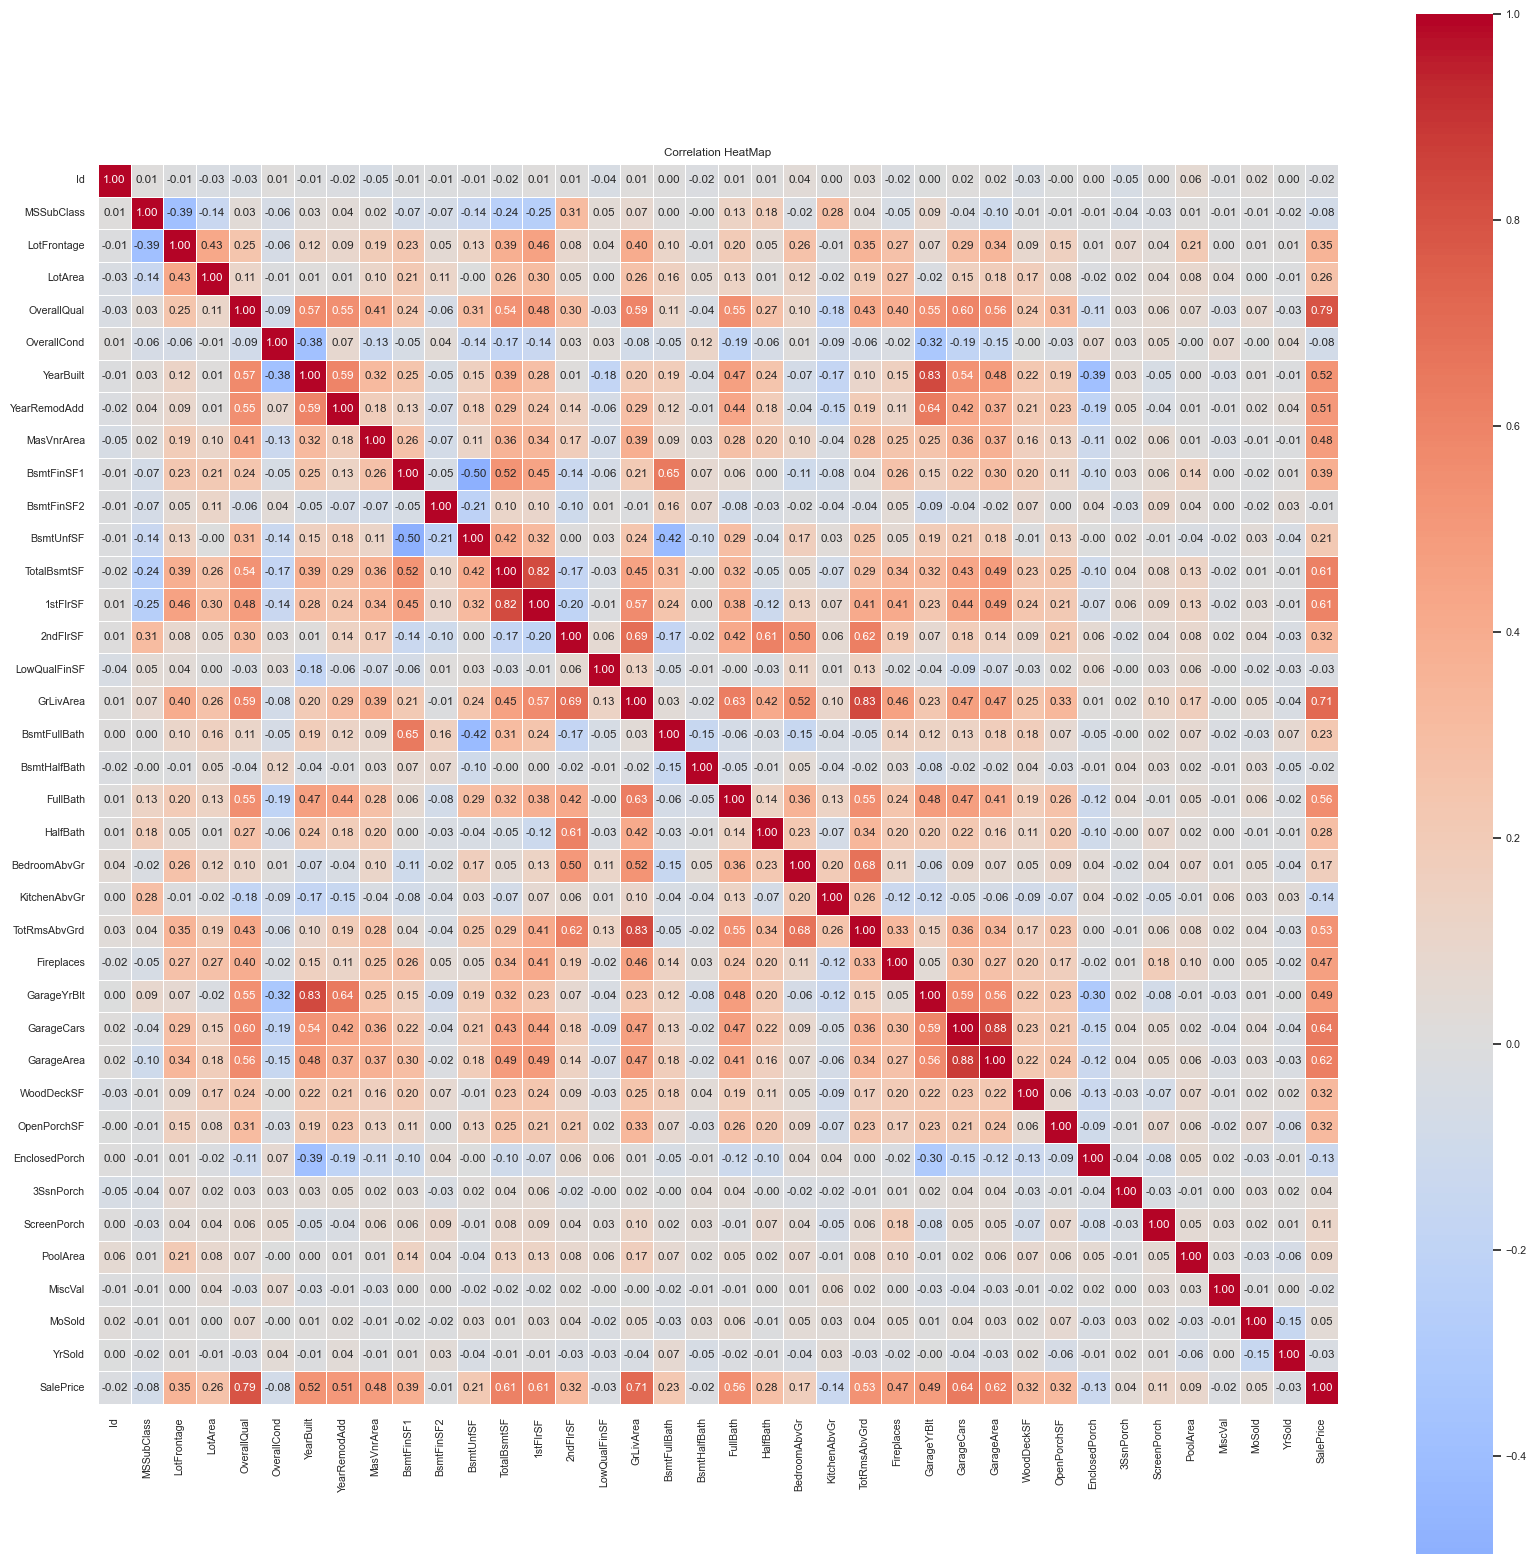

Features with Correlation Value above 0.3 LotFrontage, OverallQual, YearBuilt, YearRemodAdd, MasVnrArea, BsmtFinSF1, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, GrLivArea, FullBath, TotRmsAbvGrd, Fireplaces, GarageYrBlt, GarageCars, GarageArea, WoodDeckSF, OpenPorchSF, SalePrice


In [52]:
show_correlation_map(train_df)

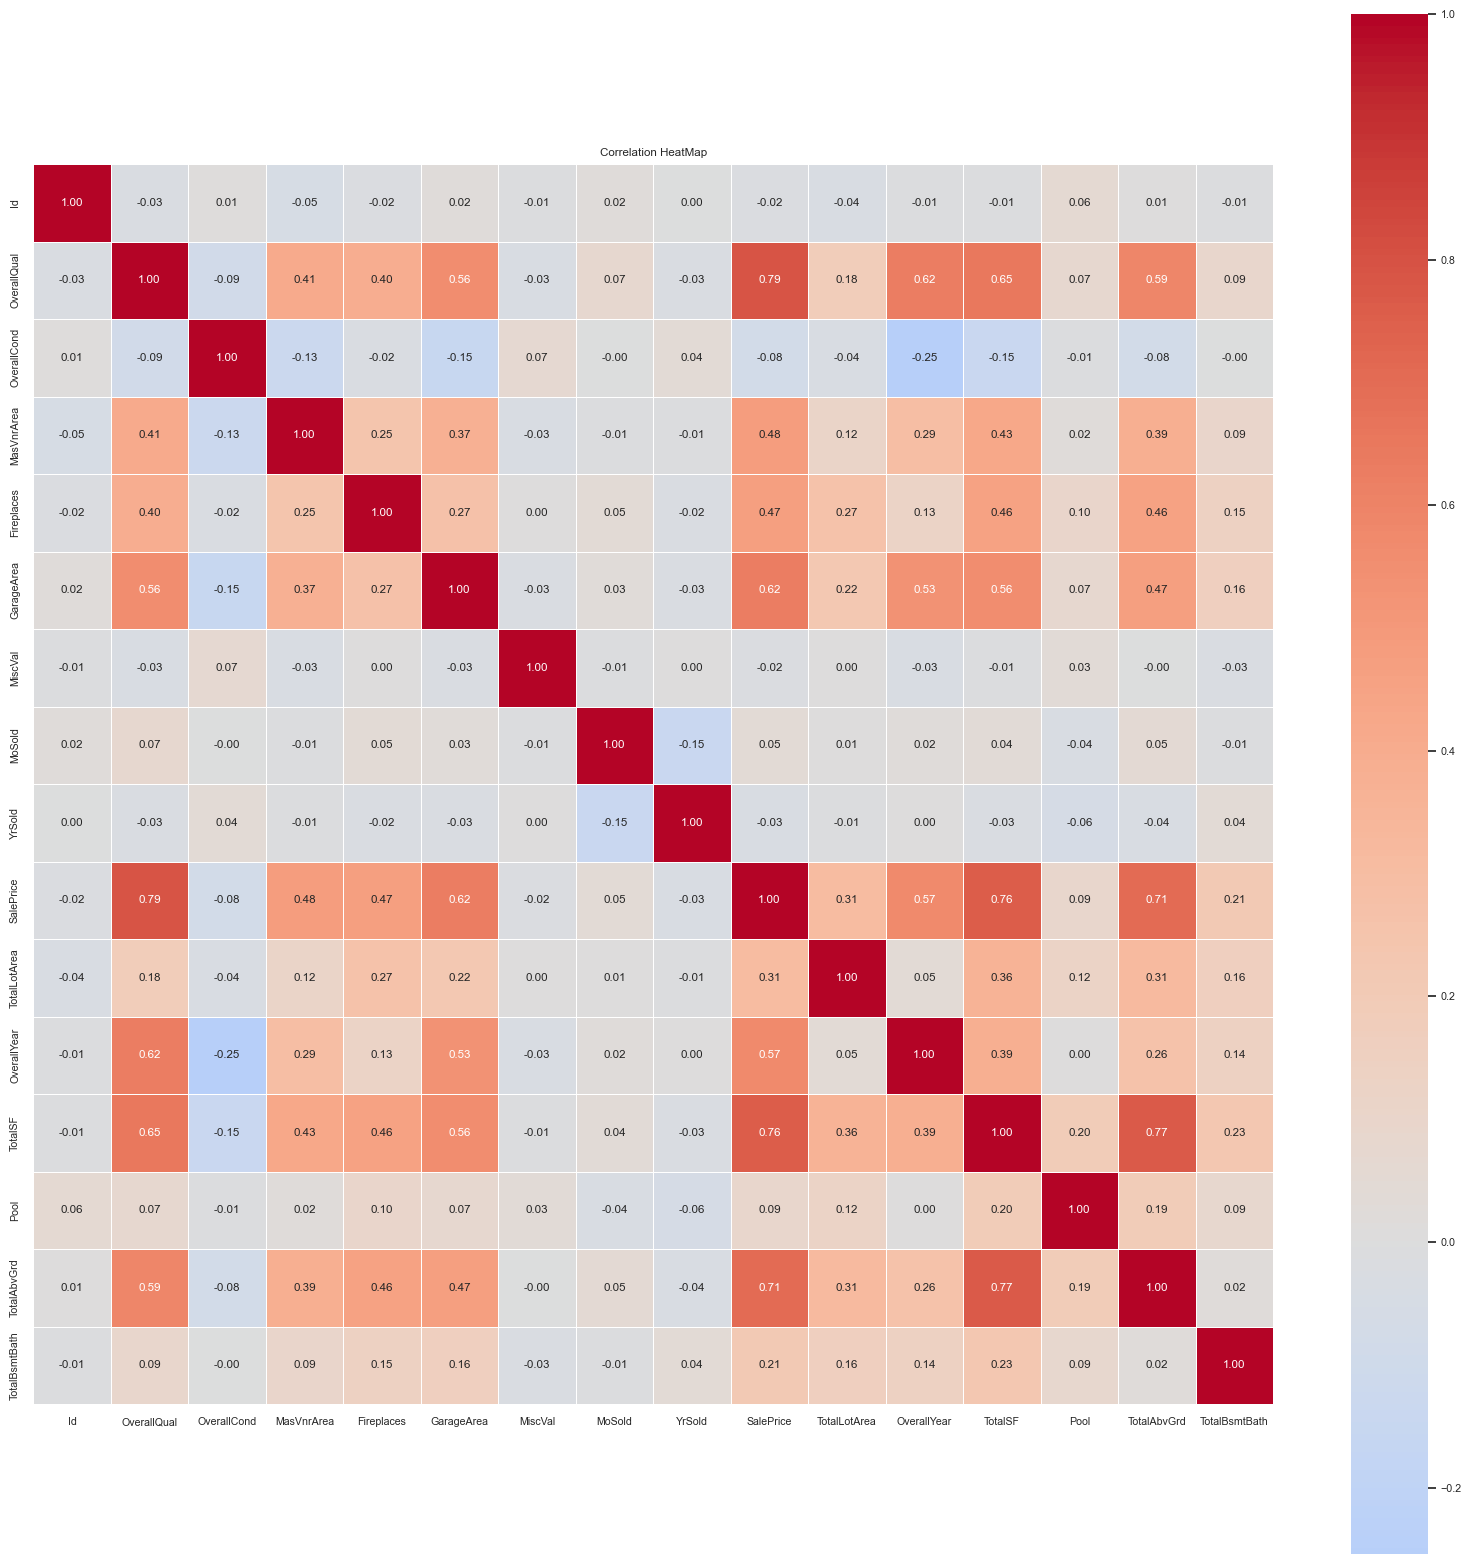

In [122]:
train_dataset = train_df.copy()

# LotArea and LotFrantage
train_dataset.loc[:, 'TotalLotArea'] = train_dataset.loc[:, 'LotArea'] + train_dataset.loc[:, 'LotFrontage']

# YearBuilt, YearRemodAdd, GarageYrBlt
train_dataset.loc[:, 'OverallYear'] = train_dataset.loc[:, ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']].mean(axis=1).astype(int)

# BsmtFinSF1	BsmtFinSF2	BsmtUnfSF	TotalBsmtSF	1stFlrSF	2ndFlrSF	LowQualFinSF	WoodDeckSF	OpenPorchSF
train_dataset.loc[:, 'TotalSF'] = train_dataset.loc[:, ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',	'1stFlrSF',	
    '2ndFlrSF',	'LowQualFinSF',	'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']].sum(axis=1)

# pool area
train_dataset.loc[:, 'Pool'] = train_dataset.loc[:, 'PoolArea'].apply(lambda x: 1 if x > 0 else 0)

# total above
train_dataset.loc[:, 'TotalAbvGrd'] = train_dataset.loc[:, ['GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd']].sum(axis=1)

# BsmtFullBath, BsmtHalfBath
train_dataset.loc[:, 'TotalBsmtBath'] = train_dataset.loc[:, ['BsmtFullBath', 'BsmtHalfBath']].sum(axis=1)


train_dataset = train_dataset.drop(columns=[
    'LotArea', 'LotFrontage', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt',
    'BsmtFinSF1', 'BsmtFinSF2',	'BsmtUnfSF', 'TotalBsmtSF',	'1stFlrSF',	
    '2ndFlrSF',	'LowQualFinSF',	'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 
    '3SsnPorch', 'ScreenPorch', 'FullBath', 'HalfBath', 'GarageCars', 'PoolArea',
    'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
    'BsmtFullBath', 'BsmtHalfBath'
])

show_correlation_map(train_dataset)

In [114]:
['OverallQual', 'MasVnrArea', 'Fireplaces', 'GarageArea', 'OverallYear', 'TotalSF', 'TotalAbvGrd', 'TotalBsmtBath']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 59 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MSSubClass      1460 non-null   object 
 1   MSZoning        1460 non-null   object 
 2   Street          1460 non-null   object 
 3   Alley           1460 non-null   object 
 4   LotShape        1460 non-null   object 
 5   LandContour     1460 non-null   object 
 6   Utilities       1460 non-null   object 
 7   LotConfig       1460 non-null   object 
 8   LandSlope       1460 non-null   object 
 9   Neighborhood    1460 non-null   object 
 10  Condition1      1460 non-null   object 
 11  Condition2      1460 non-null   object 
 12  BldgType        1460 non-null   object 
 13  HouseStyle      1460 non-null   object 
 14  OverallQual     1460 non-null   float64
 15  OverallCond     1460 non-null   float64
 16  RoofStyle       1460 non-null   object 
 17  RoofMatl        1460 non-null   o

In [113]:
train_dataset.loc[:, ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']]

KeyError: "None of [Index(['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'], dtype='object')] are in the [columns]"

<Axes: >

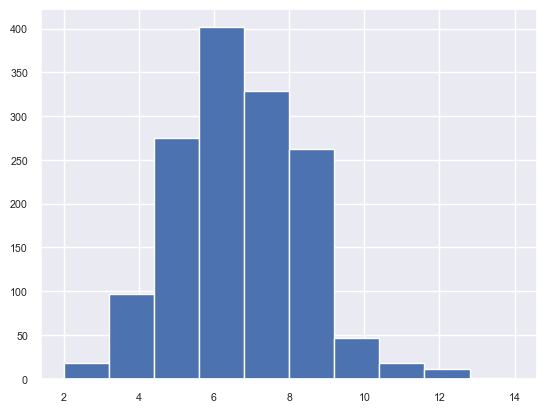

In [74]:
train_df['TotRmsAbvGrd'].hist()

<Axes: >

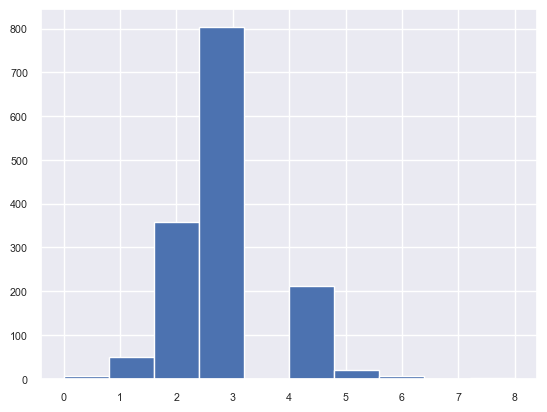

In [71]:
train_df['BedroomAbvGr'].hist()

<Axes: >

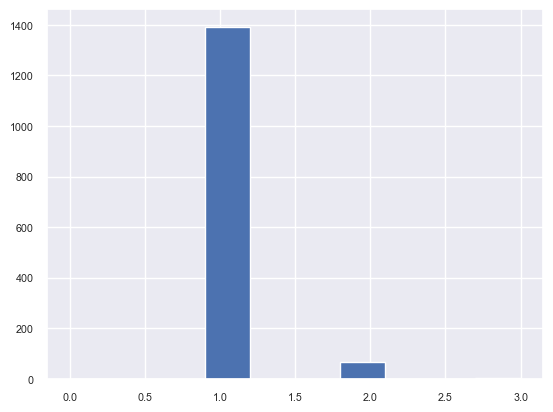

In [72]:
train_df['KitchenAbvGr'].hist()

In [76]:
train_df[['FullBath', 'HalfBath']]

,FullBath,HalfBath
0,2,1
1,2,0
2,2,1
3,1,0
4,2,1
...,...,...
1455,2,1
1456,2,0
1457,2,0
1458,1,0
